Please draw rectangles on the first image to select the ROIs.
ROI selected: (582, 798, 1472, 1706)
ROI selected: (740, 1186, 424, 1780)


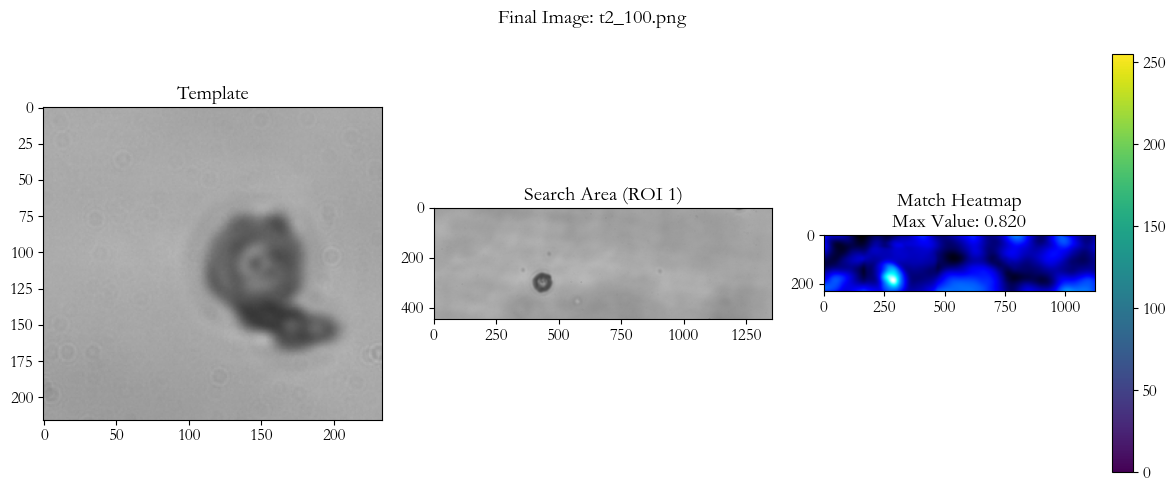

In [1]:
import numpy as np
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
import re

#文件读取函数
def get_sorted_files(folder_path, other_position='front'):
    # 获取所有文件列表
    all_files = os.listdir(folder_path)
    
    # 分离符合t2格式的图片和其他文件
    image_files = [
        f for f in all_files 
        if re.fullmatch(r't2_\d+\.png', f, re.IGNORECASE)
    ]
    other_files = [
        f for f in all_files 
        if not re.fullmatch(r't2_\d+\.png', f, re.IGNORECASE)
    ]

    # 定义数字提取函数
    def extract_number(filename):
        match = re.search(r't2_(\d+)\.png', filename, re.IGNORECASE)
        return int(match.group(1)) if match else 0

    # 对图片文件进行自然排序
    sorted_images = sorted(image_files, key=extract_number)

    # 组合最终结果
    if other_position == 'front':
        return other_files + sorted_images
    elif other_position == 'end':
        return sorted_images + other_files
    else:
        return sorted_images

#路径导入
folder_path = "C:\\Users\\PC\\Desktop\\final year project\\pictures\\1.24\\t2"
sorted_files = get_sorted_files(folder_path, other_position='front')
full_paths = [os.path.join(folder_path, f) for f in sorted_files]

# 时间间隔
time_interval = 0.1

# 存储所有图片的距离
output_distances = []  

# 检查是否有图片
if not full_paths:
    raise ValueError("No images found in the folder.")

# 存储选中的点坐标
rois = []

# 缩放比例
scale = 0.5  # 图像缩小到 50%

# OpenCV 鼠标回调函数
def select_rois(event, x, y, flags, param):
    """
    OpenCV 鼠标回调函数，用于选择矩形区域的坐标。
    """
    global rois, drawing, ix, iy

    if event == cv2.EVENT_LBUTTONDOWN:  # 鼠标左键按下
        drawing = True
        ix, iy = x, y  # 记录起始点

    elif event == cv2.EVENT_LBUTTONUP:  # 鼠标左键释放
        drawing = False
        # 将坐标转换为原始图像的坐标
        x_original = int(x / scale)
        y_original = int(y / scale)
        ix_original = int(ix / scale)
        iy_original = int(iy / scale)
        # 记录 ROI 的坐标 (y_min, y_max, x_min, x_max)
        rois.append((min(iy_original, y_original), max(iy_original, y_original), 
                     min(ix_original, x_original), max(ix_original, x_original)))
        print(f"ROI selected: {rois[-1]}")
        # 在原始图像上绘制矩形
        cv2.rectangle(original_image, (ix_original, iy_original), (x_original, y_original), (0, 255, 0), 2)
        # 更新显示图像
        resized_image = cv2.resize(original_image, (0, 0), fx=scale, fy=scale)
        cv2.imshow("Select ROIs", resized_image)

# Step 1: 在第一张图片上选择 ROI
print("Please draw rectangles on the first image to select the ROIs.")
first_image_path = full_paths[0]
first_image = Image.open(first_image_path).convert("L")  # 转换为灰度图像
first_image_array = np.array(first_image)

# 将图像转换为 OpenCV 格式（BGR）
original_image = cv2.cvtColor(first_image_array, cv2.COLOR_GRAY2BGR)

# 调整图像大小
resized_image = cv2.resize(original_image, (0, 0), fx=scale, fy=scale)

# 创建窗口并绑定鼠标回调函数
cv2.namedWindow("Select ROIs", cv2.WINDOW_NORMAL)
cv2.setMouseCallback("Select ROIs", select_rois)

# 显示图像并等待用户选择 ROI
while True:
    cv2.imshow("Select ROIs", resized_image)
    key = cv2.waitKey(1) & 0xFF
    if key == 27:  # 按下 ESC 键退出
        break
    if key == 13:  # 按下回车键确认选择完成
        if len(rois) >= 2:  # 至少选择一个 template 和一个 ROI
            break
        else:
            print("Please select at least one template and one ROI.")

cv2.destroyAllWindows()

# 检查是否选择了至少两个 ROI
if len(rois) < 2:
    raise ValueError("Please select at least two ROIs.")

# Step 2: 对每个 ROI 进行模板匹配
dynamics_global_coordinates=[]
# 提取第一个 ROI 作为模板
template_roi = rois[0]

for image_path in full_paths:
    image = Image.open(image_path).convert("L")  # 转换为灰度图像
    image_array = np.array(image)
    template = image_array[template_roi[0]:template_roi[1], template_roi[2]:template_roi[3]]
    global_coordinates = []  # 存储每个 ROI 的最佳匹配位置的全局坐标
    for i, roi in enumerate(rois[1:]):  # 从第二个 ROI 开始
        # 提取当前 ROI
        image_roi = image_array[roi[0]:roi[1], roi[2]:roi[3]]
        
        # 检查 ROI 是否比模板小
        if image_roi.shape[0] < template.shape[0] or image_roi.shape[1] < template.shape[1]:
            print(f"ROI {i + 1} is smaller than the template. Skipping this ROI.")
            continue  # 跳过这个 ROI
        
        result = cv2.matchTemplate(image_roi, template, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        
        # 新增最终图像可视化 ▼
        if image_path == full_paths[-1]:  # 仅处理最后一张图
            # 生成匹配结果热力图
            result_norm = cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            result_heat = cv2.applyColorMap(result_norm, cv2.COLORMAP_HOT)
            
            # 创建可视化面板
            plt.figure(figsize=(12, 5))
            plt.subplot(131)
            plt.imshow(cv2.cvtColor(template, cv2.COLOR_GRAY2RGB))
            plt.title('Template')
            
            plt.subplot(132)
            plt.imshow(cv2.cvtColor(image_roi, cv2.COLOR_GRAY2RGB))
            plt.title(f'Search Area (ROI {i+1})')
            
            plt.subplot(133)
            plt.imshow(result_heat)
            plt.title(f'Match Heatmap\nMax Value: {max_val:.3f}')
            plt.colorbar()
            
            plt.suptitle(f'Final Image: {os.path.basename(image_path)}')
            plt.tight_layout()
            plt.show()

        # 最佳匹配位置
        top_left = max_loc
        bottom_right = (top_left[0] + template.shape[1], top_left[1] + template.shape[0])
        
        # 将匹配位置转换到整体坐标系
        top_left_global = (top_left[0] + roi[2], top_left[1] + roi[0])
        bottom_right_global = (bottom_right[0] + roi[2], bottom_right[1] + roi[0])
        
        # 计算质心
        centroid = ((top_left_global[0] + bottom_right_global[0]) / 2, 
                    (top_left_global[1] + bottom_right_global[1]) / 2)
        
        # 将全局坐标保存到列表中
        global_coordinates.append(centroid)
    dynamics_global_coordinates.append(global_coordinates)

# Step 3: 在最后一张图像上显示 ROI 区域和匹配最佳的点
# 加载最后一张图像
last_image_path = full_paths[-1]
last_image = Image.open(last_image_path).convert("L")  # 转换为灰度图像
last_image_array = np.array(last_image)

# 将图像转换为 OpenCV 格式（BGR）
output_image = cv2.cvtColor(last_image_array, cv2.COLOR_GRAY2BGR)

# 绘制 ROI 区域
for i, roi in enumerate(rois):
    # 绘制矩形框
    cv2.rectangle(output_image, (roi[2], roi[0]), (roi[3], roi[1]), (0, 255, 0), 2)  # 绿色矩形框
    # 添加 ROI 编号
    cv2.putText(output_image, f"ROI {i + 1}", (roi[2] + 10, roi[0] + 20), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)  # 绿色文本

# 绘制匹配最佳的点
for i, positions in enumerate(dynamics_global_coordinates[-1]):  # 取最后一张图的匹配结果
    if positions:  # 如果存在匹配结果
        x = int(positions[0])  # 质心的 x 坐标
        y = int(positions[1])  # 质心的 y 坐标
        # 绘制红色圆点
        cv2.circle(output_image, (x, y), 5, (0, 0, 255), -1)  # 红色圆点
        # 添加匹配点编号
        cv2.putText(output_image, f"Match {i + 1}", (x + 10, y - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)  # 红色文本

# 调整图像大小以便显示
resized_output_image = cv2.resize(output_image, (0, 0), fx=scale, fy=scale)

# 显示结果
cv2.imshow("Final Image with ROIs and Matched Points", resized_output_image)
cv2.waitKey(0)  # 等待用户按键
cv2.destroyAllWindows()


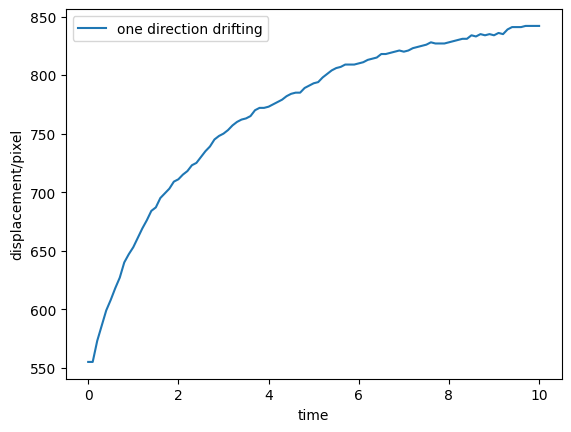

In [50]:
import numpy as np
import matplotlib.pyplot as plt
#选择研究的微珠运动方向
direction='x'
#选择微珠序号
bead_index=1
def switch(case):
    cases = {
    'x': 0,
    'y': 1
    }
    return cases.get(case, 'default Case')
direction = switch(direction)
one_bead_axis=np.array(dynamics_global_coordinates).T[direction][bead_index-1]
# 创建时间轴
time_points = np.linspace(0, time_interval * (len(full_paths) - 1), len(full_paths))
plt.plot(time_points,one_bead_axis,label='one direction drifting')
plt.xlabel('time')
plt.ylabel('displacement/pixel')
plt.legend()
plt.show()

In [51]:
import pandas as pd

# 创建数据框架
df = pd.DataFrame({
    '时间(s)': time_points
})

# 添加所有微珠的位移数据
for bead_idx in range(len(dynamics_global_coordinates[0])):
    # X方向
    df[f'微珠{bead_idx+1}_x'] = np.array(dynamics_global_coordinates).T[0][bead_idx]
    # Y方向 
    df[f'微珠{bead_idx+1}_y'] = np.array(dynamics_global_coordinates).T[1][bead_idx]

# 保存到Excel（强制覆盖模式）
save_path = "C:\\Users\\PC\\Desktop\\final year project\\微珠运动数据.xlsx"

try:
    # 先删除已存在文件
    if os.path.exists(save_path):
        os.remove(save_path)
    # 写入新文件
    df.to_excel(save_path, index=False, engine='openpyxl')
    print(f"数据已成功覆盖保存至：{save_path}")
except PermissionError:
    print(f"错误：文件被Excel或其他程序占用，请关闭文件后重试")
except Exception as e:
    print(f"保存失败，错误类型：{type(e).__name__}\n详细信息：{str(e)}")

数据已成功覆盖保存至：C:\Users\PC\Desktop\final year project\微珠运动数据.xlsx
